## WEEK 3: 데이터 전처리 및 피쳐 엔지니어링
### 💡 TASK 1: 데이터 전처리

In [1]:
!pip install yfinance matplotlib seaborn pandas numpy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Google Colab에서 한글 폰트 설정하기
!pip install -q matplotlib
!pip install -q --upgrade matplotlib
!pip install -q koreanize-matplotlib

import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.9 MB/s eta 0:00:00


In [3]:
# 데이터 수집 기간 설정('2015-01-01' ~ '2025-03-17')
start_date = '2015-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"데이터 수집 기간: {start_date} ~ {end_date}")

# 애플, 마이크로소프트, 구글 데이터 다운로드
tickers = ['AAPL', 'MSFT', 'GOOGL']
stock_names = ['Apple', 'Microsoft', 'Google']

# 데이터 다운로드 및 저장
stocks_data = {}
for ticker, name in zip(tickers, stock_names):
    data = yf.download(ticker, start=start_date, end=end_date)

    # 멀티인덱스 컬럼 처리
    if isinstance(data.columns[0], tuple):
        data.columns = [col[0] for col in data.columns]

    # 일별 수익률 계산
    data['Daily_Return'] = data['Close'].pct_change() * 100

    # 변동성 지표 (20일 롤링 표준편차)
    data['Volatility_20d'] = data['Daily_Return'].rolling(window=20).std()

    # 거래량 변화율
    data['Volume_Change'] = data['Volume'].pct_change() * 100

    # 가격 모멘텀 (20일 이동평균 대비 현재가 비율)
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['Price_Momentum'] = (data['Close'] / data['MA20'] - 1) * 100

    # 시계열 특성 추가
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['Month_Name'] = data.index.strftime('%B')
    data['Day_of_Week'] = data.index.dayofweek

    # 데이터 저장
    stocks_data[name] = data
    print(f"다운로드 완료: {name} 주식 데이터 {len(data)}행")

# 각 주식의 기본 정보 출력
for name, data in stocks_data.items():
    print(f"\n===== {name} 주식 데이터 기본 정보 =====")
    print(f"분석 기간: {data.index.min().strftime('%Y-%m-%d')} ~ {data.index.max().strftime('%Y-%m-%d')}")
    print(f"총 거래일 수: {len(data)}일")
    print(f"결측치: {data[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum().sum()}개")

    # 기초 통계량
    print(f"\n일별 수익률 기초 통계량:")
    print(data['Daily_Return'].describe())

데이터 수집 기간: 2015-01-01 ~ 2025-03-24
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


다운로드 완료: Apple 주식 데이터 2570행


[*********************100%***********************]  1 of 1 completed


다운로드 완료: Microsoft 주식 데이터 2570행


[*********************100%***********************]  1 of 1 completed

다운로드 완료: Google 주식 데이터 2570행

===== Apple 주식 데이터 기본 정보 =====
분석 기간: 2015-01-02 ~ 2025-03-21
총 거래일 수: 2570일
결측치: 0개

일별 수익률 기초 통계량:
count    2569.000000
mean        0.101550
std         1.794178
min       -12.864714
25%        -0.739810
50%         0.095038
75%         1.013931
max        11.980849
Name: Daily_Return, dtype: float64

===== Microsoft 주식 데이터 기본 정보 =====
분석 기간: 2015-01-02 ~ 2025-03-21
총 거래일 수: 2570일
결측치: 0개

일별 수익률 기초 통계량:
count    2569.000000
mean        0.103319
std         1.708234
min       -14.739053
25%        -0.680686
50%         0.092459
75%         0.973644
max        14.216876
Name: Daily_Return, dtype: float64

===== Google 주식 데이터 기본 정보 =====
분석 기간: 2015-01-02 ~ 2025-03-21
총 거래일 수: 2570일
결측치: 0개

일별 수익률 기초 통계량:
count    2569.000000
mean        0.087321
std         1.798135
min       -11.634153
25%        -0.766432
50%         0.120263
75%         0.968057
max        16.258419
Name: Daily_Return, dtype: float64


In [22]:
for name, data in stocks_data.items():
    missing_values = data.isnull().sum()
    print(f"\n{name} 결측치 현황:")
    print(missing_values[missing_values > 0])  # 결측치가 있는 컬럼만 출력

    # 주가 기본 데이터 결측치 처리 (선형 보간법 적용)
    cols_to_interpolate = ['Open', 'High', 'Low', 'Close', 'Volume']
    data[cols_to_interpolate] = data[cols_to_interpolate].interpolate(method='linear')

    # 파생변수 결측치 처리
    derived_cols = ['Daily_Return', 'Volatility_20d', 'Volume_Change', 'MA20', 'Price_Momentum']
    for col in derived_cols:
        # 첫 유효 데이터 이후 결측치만 보간
        first_valid_idx = data[col].first_valid_index()
        if first_valid_idx is not None:
            valid_mask = data.index >= first_valid_idx
            data.loc[valid_mask, col] = data.loc[valid_mask, col].interpolate(method='linear')



Apple 결측치 현황:
Daily_Return                   1
Volatility_20d                20
Volume_Change                  1
MA20                          19
Price_Momentum                19
Daily_Return_Cleaned           1
Volatility_20d_Cleaned        20
Daily_Return_Z                 1
Volatility_20d_Z              20
Volume_Change_Z                1
Daily_Return_Robust            1
Recovery_Rate_10d             10
EERR                        2469
Volume_Z                     251
Volatility_Z                 271
VVAS                         271
RSI                           13
BB_Middle                     19
BB_Upper                      19
BB_Lower                      19
BB_Width                      19
BB_Percent_B                  19
MA50                          49
MA100                         99
MA200                        199
Next_Day_Return                1
Future_Volatility_Change      30
dtype: int64

Microsoft 결측치 현황:
Daily_Return                   1
Volatility_20d               

In [23]:
for name, data in stocks_data.items():
    print(f"\n{name} 이상치 처리:")

    # 일별 수익률(Daily_Return) 이상치 처리 - IQR 방식
    Q1_return = data['Daily_Return'].quantile(0.25)
    Q3_return = data['Daily_Return'].quantile(0.75)
    IQR_return = Q3_return - Q1_return

    lower_bound_return = Q1_return - 3 * IQR_return  # 더 유연한 경계 (3*IQR)
    upper_bound_return = Q3_return + 3 * IQR_return

    # 이상치 개수 확인
    outliers_count_before = ((data['Daily_Return'] < lower_bound_return) |
                             (data['Daily_Return'] > upper_bound_return)).sum()
    print(f"일별 수익률 이상치 개수(처리 전): {outliers_count_before}")

    # 이상치 윙소화(winsorizing) 처리
    data['Daily_Return_Cleaned'] = data['Daily_Return'].clip(lower=lower_bound_return, upper=upper_bound_return)

    # 거래량(Volume) 이상치 처리 - 로그 변환
    # 거래량 0 이하 체크
    volume_zeros = (data['Volume'] <= 0).sum()
    print(f"거래량이 0 이하인 값 개수: {volume_zeros}")

    # 0 이하인 경우 직전 값으로 대체
    if volume_zeros > 0:
        data.loc[data['Volume'] <= 0, 'Volume'] = data['Volume'].shift(1)

    # 로그 변환으로 분포 정규화
    data['Volume_Log'] = np.log1p(data['Volume'])  # log(1+x) 변환


Apple 이상치 처리:
일별 수익률 이상치 개수(처리 전): 26
거래량이 0 이하인 값 개수: 0

Microsoft 이상치 처리:
일별 수익률 이상치 개수(처리 전): 28
거래량이 0 이하인 값 개수: 0

Google 이상치 처리:
일별 수익률 이상치 개수(처리 전): 24
거래량이 0 이하인 값 개수: 0


In [24]:
for name, data in stocks_data.items():
    print(f"\n{name} 데이터 정규화/표준화:")

    # Min-Max 정규화 (종가)
    data['Close_Norm'] = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())

    # Z-점수 표준화 (중요 지표들)
    data['Daily_Return_Z'] = (data['Daily_Return'] - data['Daily_Return'].mean()) / data['Daily_Return'].std()
    data['Volatility_20d_Z'] = (data['Volatility_20d'] - data['Volatility_20d'].mean()) / data['Volatility_20d'].std()

    print(f"종가 정규화 범위: {data['Close_Norm'].min():.4f} ~ {data['Close_Norm'].max():.4f}")
    print(f"일별 수익률 Z-점수 통계: 평균={data['Daily_Return_Z'].mean():.4f}, 표준편차={data['Daily_Return_Z'].std():.4f}")



Apple 데이터 정규화/표준화:
종가 정규화 범위: 0.0000 ~ 1.0000
일별 수익률 Z-점수 통계: 평균=0.0000, 표준편차=1.0000

Microsoft 데이터 정규화/표준화:
종가 정규화 범위: 0.0000 ~ 1.0000
일별 수익률 Z-점수 통계: 평균=-0.0000, 표준편차=1.0000

Google 데이터 정규화/표준화:
종가 정규화 범위: 0.0000 ~ 1.0000
일별 수익률 Z-점수 통계: 평균=-0.0000, 표준편차=1.0000


**📌 일별 수익률 이상치 처리 전후 비교**

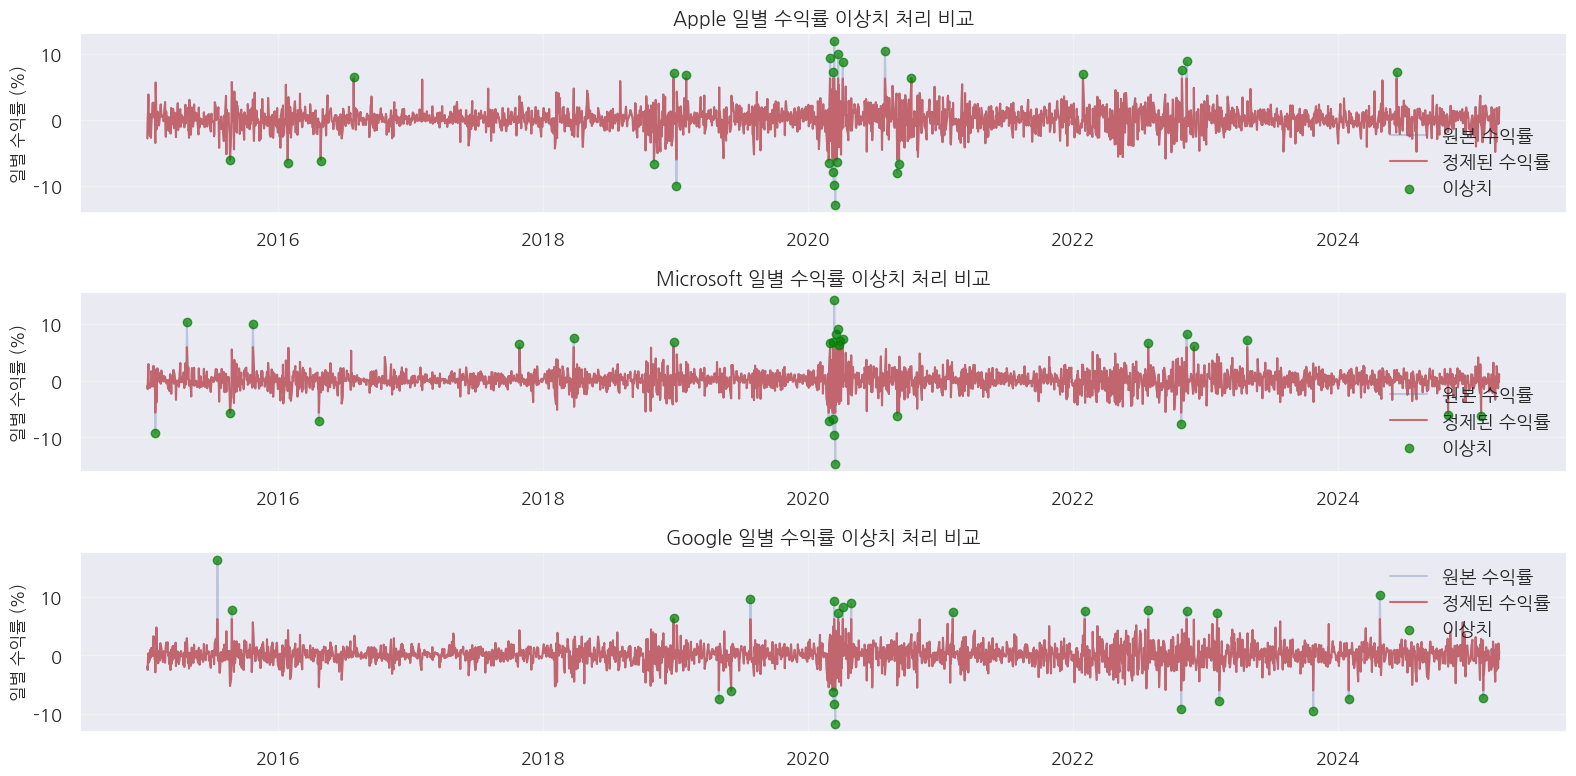

In [14]:
plt.figure(figsize=(16, 8))
for i, (name, data) in enumerate(stocks_data.items(), 1):
    plt.subplot(3, 1, i)

    plt.plot(data.index, data['Daily_Return'], 'b-', alpha=0.3, label='원본 수익률')
    plt.plot(data.index, data['Daily_Return_Cleaned'], 'r-', alpha=0.8, label='정제된 수익률')

    # 이상치 강조 표시
    outliers = data[((data['Daily_Return'] < data['Daily_Return_Cleaned']) |
                    (data['Daily_Return'] > data['Daily_Return_Cleaned']))]
    plt.scatter(outliers.index, outliers['Daily_Return'], color='green', alpha=0.7,
               label='이상치', zorder=5)

    plt.title(f'{name} 일별 수익률 이상치 처리 비교', fontsize=14)
    plt.ylabel('일별 수익률 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()


**📌 거래량 로그 변환 효과 비교**

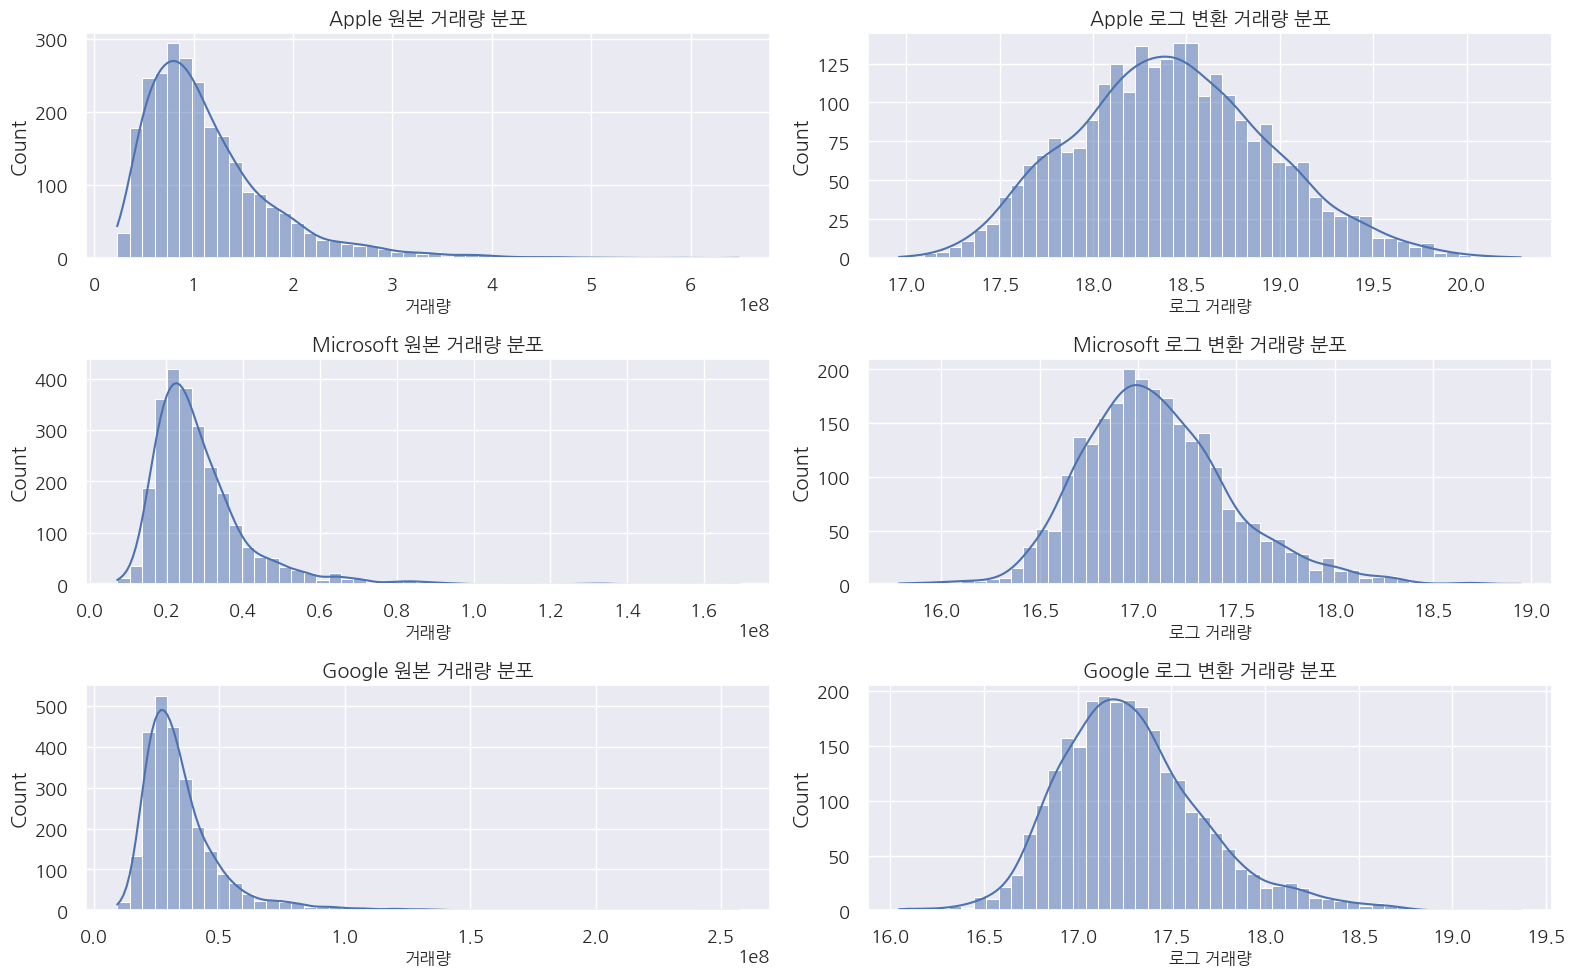

In [15]:
plt.figure(figsize=(16, 10))
for i, (name, data) in enumerate(stocks_data.items(), 1):
    plt.subplot(3, 2, i*2-1)
    sns.histplot(data['Volume'], bins=50, kde=True)
    plt.title(f'{name} 원본 거래량 분포', fontsize=14)
    plt.xlabel('거래량', fontsize=12)

    plt.subplot(3, 2, i*2)
    sns.histplot(data['Volume_Log'], bins=50, kde=True)
    plt.title(f'{name} 로그 변환 거래량 분포', fontsize=14)
    plt.xlabel('로그 거래량', fontsize=12)

plt.tight_layout()
plt.show()

### 💡 TASK 2: 피쳐 엔지니어링
- Extreme Event Recovery Rate (EERR) - 급락 이벤트 후 회복률
- Volume-Volatility Anomaly Score (VVAS) - 거래량/변동성 불일치 지표

In [16]:
for name, data in stocks_data.items():
    print(f"\n{name} 핵심 파생변수:")

    # Extreme Event Recovery Rate (EERR) - 급락 이벤트 후 회복률
    data['Large_Drop'] = data['Daily_Return'] <= -3  # 급락 이벤트 식별
    data['Recovery_Rate_10d'] = data['Close'].pct_change(10) * 100  # 10일 후 가격 변화율
    data['EERR'] = np.where(data['Large_Drop'], data['Recovery_Rate_10d'].shift(-10), np.nan)

    # EERR 통계
    eerr_mean = data['EERR'].mean()
    eerr_median = data['EERR'].median()
    print(f"EERR 평균: {eerr_mean:.2f}%, 중앙값: {eerr_median:.2f}%")
    print(f"EERR 양수 비율: {(data['EERR'] > 0).mean() * 100:.2f}%")  # 회복 성공률

    # Volume-Volatility Anomaly Score (VVAS) - 거래량/변동성 불일치 지표
    # Z-Score 계산 (252 거래일 = 1년)
    data['Volume_Z'] = (data['Volume'] - data['Volume'].rolling(252).mean()) / data['Volume'].rolling(252).std()
    data['Volatility_Z'] = (data['Volatility_20d'] - data['Volatility_20d'].rolling(252).mean()) / data['Volatility_20d'].rolling(252).std()
    data['VVAS'] = data['Volume_Z'] - data['Volatility_Z']

    print(f"VVAS 평균: {data['VVAS'].mean():.2f}, 표준편차: {data['VVAS'].std():.2f}")
    print(f"비정상적으로 높은 VVAS 발생 일수: {(data['VVAS'] > 2).sum()}일")


Apple 핵심 파생변수:
EERR 평균: 1.16%, 중앙값: 1.81%
EERR 양수 비율: 2.22%
VVAS 평균: -0.19, 표준편차: 1.20
비정상적으로 높은 VVAS 발생 일수: 73일

Microsoft 핵심 파생변수:
EERR 평균: 2.11%, 중앙값: 3.10%
EERR 양수 비율: 2.14%
VVAS 평균: -0.04, 표준편차: 1.21
비정상적으로 높은 VVAS 발생 일수: 93일

Google 핵심 파생변수:
EERR 평균: 1.14%, 중앙값: 1.53%
EERR 양수 비율: 2.33%
VVAS 평균: -0.07, 표준편차: 1.21
비정상적으로 높은 VVAS 발생 일수: 97일


**📌 파생변수 시각화 및 검증**
- EERR(Extreme Event Recovery Rate) 분석 시각화

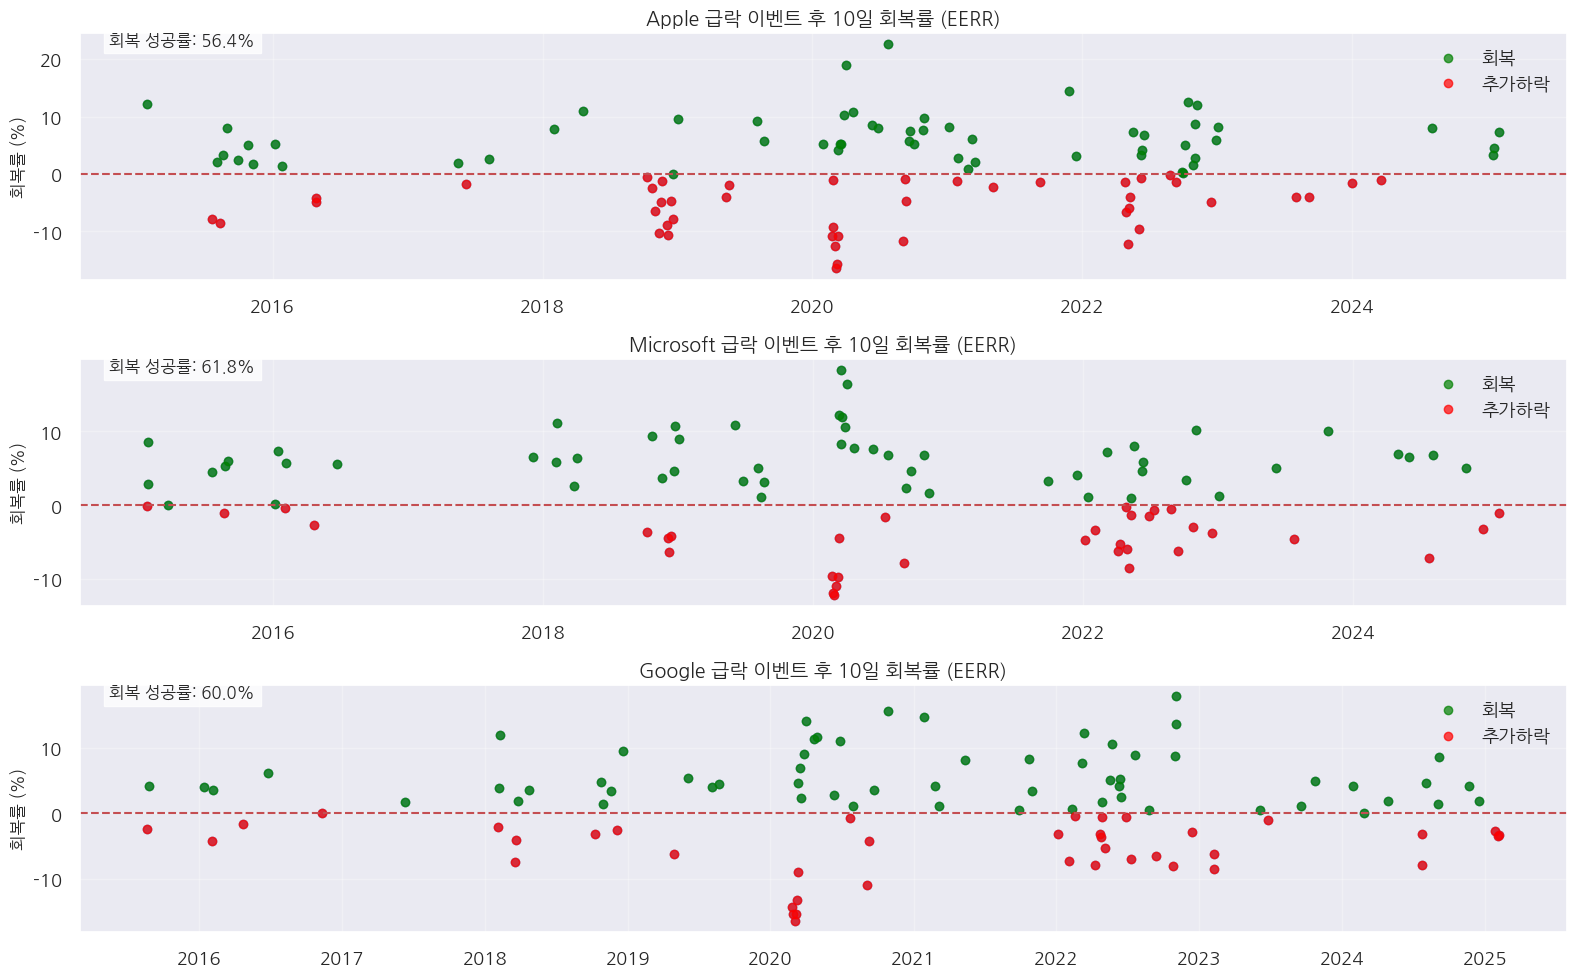

In [17]:
plt.figure(figsize=(16, 10))
for i, (name, data) in enumerate(stocks_data.items(), 1):
    plt.subplot(3, 1, i)

    # 급락 이벤트와 회복률 산점도
    valid_eerr = data.dropna(subset=['EERR'])
    plt.scatter(valid_eerr.index, valid_eerr['EERR'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')

    # 회복/추가하락 표시
    recovered = valid_eerr[valid_eerr['EERR'] > 0]
    declined = valid_eerr[valid_eerr['EERR'] <= 0]
    plt.scatter(recovered.index, recovered['EERR'], color='green', label='회복', alpha=0.7)
    plt.scatter(declined.index, declined['EERR'], color='red', label='추가하락', alpha=0.7)

    plt.title(f'{name} 급락 이벤트 후 10일 회복률 (EERR)', fontsize=14)
    plt.ylabel('회복률 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 회복 성공률 텍스트 표시
    recovery_rate = (valid_eerr['EERR'] > 0).mean() * 100
    plt.text(0.02, 0.95, f'회복 성공률: {recovery_rate:.1f}%',
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

- VVAS(Volume-Volatility Anomaly Score) 시각화

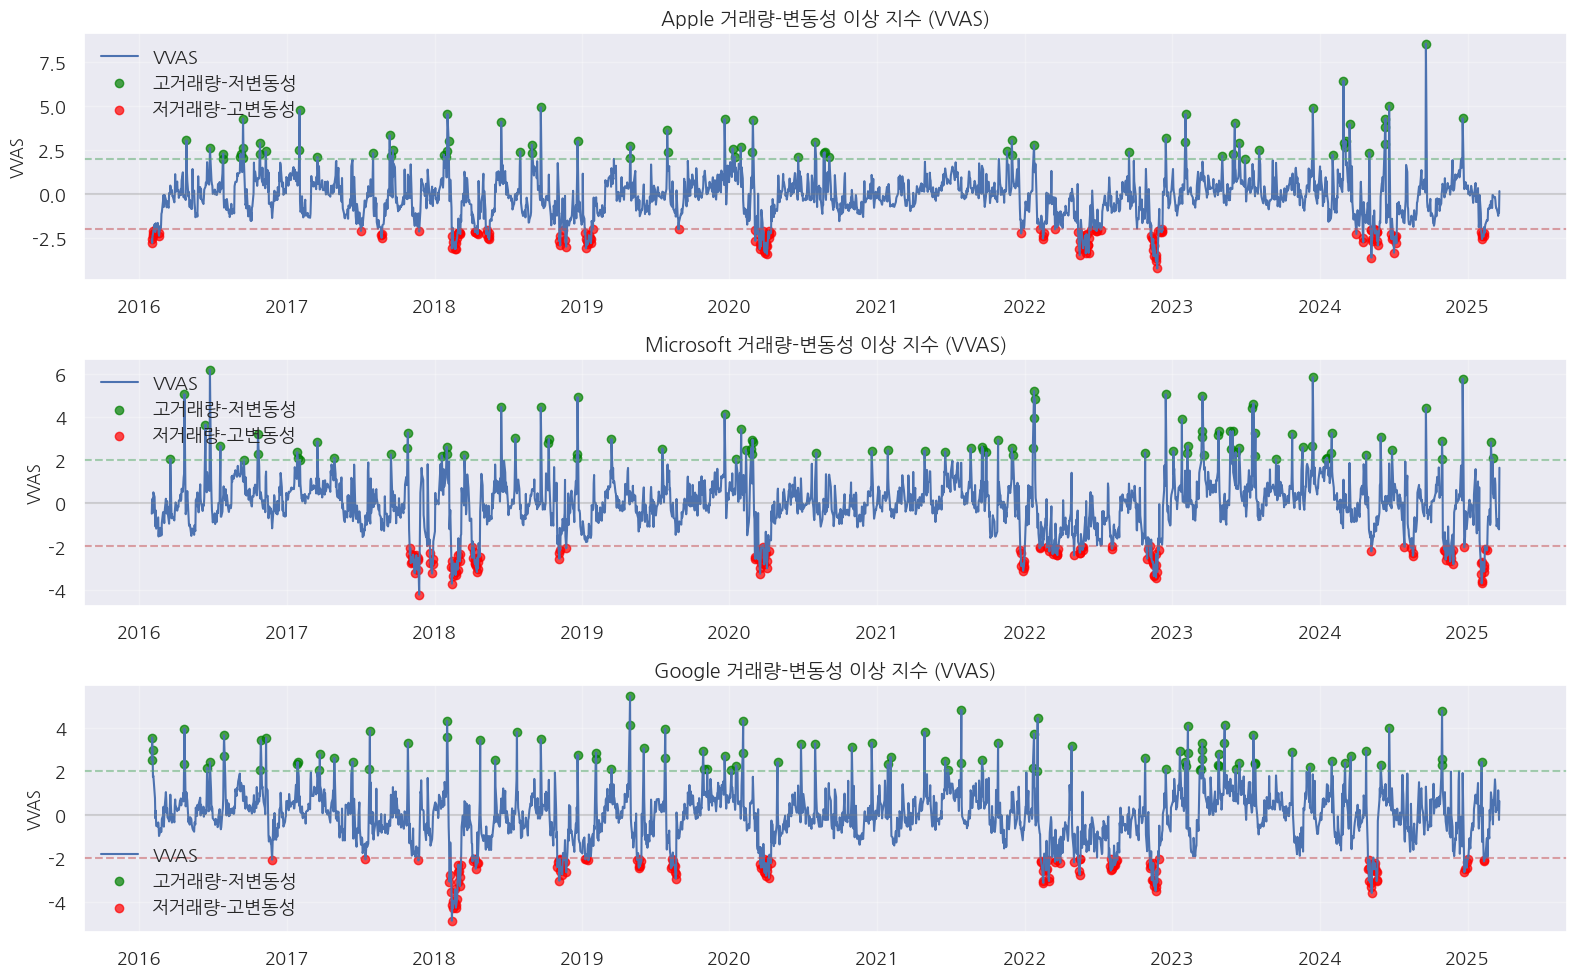

In [18]:
plt.figure(figsize=(16, 10))
for i, (name, data) in enumerate(stocks_data.items(), 1):
    plt.subplot(3, 1, i)

    # VVAS 플롯
    plt.plot(data.index, data['VVAS'], label='VVAS')

    # 이상치 표시 (VVAS > 2 또는 VVAS < -2)
    high_vvas = data[data['VVAS'] > 2]
    low_vvas = data[data['VVAS'] < -2]

    plt.scatter(high_vvas.index, high_vvas['VVAS'], color='green',
               label='고거래량-저변동성', alpha=0.7)
    plt.scatter(low_vvas.index, low_vvas['VVAS'], color='red',
               label='저거래량-고변동성', alpha=0.7)

    plt.axhline(y=2, color='g', linestyle='--', alpha=0.5)
    plt.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    plt.title(f'{name} 거래량-변동성 이상 지수 (VVAS)', fontsize=14)
    plt.ylabel('VVAS', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

- 파생변수 활용 가능성 검증

In [19]:
for name, data in stocks_data.items():
    print(f"\n{name} 파생변수 활용 검증:")

    # 다음 날 수익률과의 상관관계 분석
    data['Next_Day_Return'] = data['Daily_Return'].shift(-1)

    # 분석할 핵심 피쳐 선택
    core_features = ['Daily_Return', 'Volatility_20d', 'Volume_Change',
                     'Price_Momentum', 'VVAS', 'EERR']

    # 상관계수 계산
    correlations = {}
    for feature in core_features:
        if feature in data.columns:
            corr = data[[feature, 'Next_Day_Return']].dropna().corr().iloc[0, 1]
            correlations[feature] = corr

    # 결과 출력
    corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    print("다음 날 수익률과의 상관관계:")
    print(corr_df)

    # EERR을 활용한 간단한 전략 테스트
    # 급락 후 10일 내 회복 성공률
    recovery_success = (data['EERR'] > 0).mean() * 100

    # 급락 후 회복률이 5% 이상인 비율
    high_recovery = (data['EERR'] > 5).mean() * 100

    print(f"\nEERR 기반 전략 가능성:")
    print(f"급락 후 회복 성공률: {recovery_success:.2f}%")
    print(f"급락 후 5% 이상 회복 비율: {high_recovery:.2f}%")

    # VVAS를 활용한 간단한 전략 테스트
    # VVAS가 높을 때(2 이상) 다음 10일간 변동성 증가 여부
    data['Future_Volatility_Change'] = data['Volatility_20d'].shift(-10) - data['Volatility_20d']
    high_vvas_data = data[data['VVAS'] > 2].dropna(subset=['Future_Volatility_Change'])
    volatility_increase_after_high_vvas = (high_vvas_data['Future_Volatility_Change'] > 0).mean() * 100

    print(f"\nVVAS 기반 전략 가능성:")
    print(f"VVAS 높을 때 향후 변동성 증가 확률: {volatility_increase_after_high_vvas:.2f}%")


Apple 파생변수 활용 검증:
다음 날 수익률과의 상관관계:
          Feature  Correlation
5            EERR     0.302715
4            VVAS     0.034856
2   Volume_Change     0.004257
1  Volatility_20d    -0.001227
3  Price_Momentum    -0.013166
0    Daily_Return    -0.063880

EERR 기반 전략 가능성:
급락 후 회복 성공률: 2.22%
급락 후 5% 이상 회복 비율: 1.40%

VVAS 기반 전략 가능성:
VVAS 높을 때 향후 변동성 증가 확률: 86.30%

Microsoft 파생변수 활용 검증:
다음 날 수익률과의 상관관계:
          Feature  Correlation
5            EERR     0.343653
1  Volatility_20d     0.017369
4            VVAS     0.013722
2   Volume_Change     0.010938
3  Price_Momentum    -0.098224
0    Daily_Return    -0.138586

EERR 기반 전략 가능성:
급락 후 회복 성공률: 2.14%
급락 후 5% 이상 회복 비율: 1.36%

VVAS 기반 전략 가능성:
VVAS 높을 때 향후 변동성 증가 확률: 74.19%

Google 파생변수 활용 검증:
다음 날 수익률과의 상관관계:
          Feature  Correlation
5            EERR     0.317805
2   Volume_Change     0.020037
4            VVAS     0.003728
1  Volatility_20d    -0.004120
0    Daily_Return    -0.048629
3  Price_Momentum    -0.057786

EERR 기반 전략 가능성:
급락 

**📌 최종 피쳐셋 구성**

In [20]:
for name, data in stocks_data.items():
    print(f"\n{name} 최종 피쳐셋:")

    # 핵심 피쳐 선택
    core_features = [
        # 기본 주가 데이터
        'Open', 'High', 'Low', 'Close', 'Volume',

        # 전처리된 변수
        'Daily_Return_Cleaned', 'Volume_Log',
        'Daily_Return_Z', 'Volatility_20d_Z',

        # 핵심 파생변수
        'MA20', 'Price_Momentum', 'Volatility_20d',
        'EERR', 'VVAS',

        # 시간 특성
        'Year', 'Month', 'Quarter'
    ]

    # 최종 피쳐셋 구성
    final_data = data[core_features].copy()
    print(f"최종 피쳐셋 컬럼 수: {len(core_features)}")

    # 첫 20개 행은 이동평균 계산으로 인해 결측치가 있을 수 있으므로 제외
    clean_data = final_data.iloc[20:].dropna()
    print(f"최종 정제된 데이터 행 수: {len(clean_data)}")


Apple 최종 피쳐셋:
최종 피쳐셋 컬럼 수: 17
최종 정제된 데이터 행 수: 90

Microsoft 최종 피쳐셋:
최종 피쳐셋 컬럼 수: 17
최종 정제된 데이터 행 수: 79

Google 최종 피쳐셋:
최종 피쳐셋 컬럼 수: 17
최종 정제된 데이터 행 수: 97



### 💡 데이터 전처리 및 피쳐 엔지니어링 정리

**1. 데이터 전처리 요약**
- 결측치: 선형 보간법으로 처리
- 이상치: 윙소화(Winsorizing) 방법으로 경계값 설정하여 처리
- 거래량: 로그 변환으로 분포 정규화
- 정규화/표준화: Min-Max 정규화와 Z-점수 표준화 적용

**2. 피쳐 엔지니어링 요약**
- EERR(Extreme Event Recovery Rate): 급락 이후 회복률 지표
- VVAS(Volume-Volatility Anomaly Score): 거래량과 변동성의 불일치 지표

**3. 새로운 파생변수 활용 가능성**
- EERR: 급락 이후 회복 패턴 포착하여 반등 매매 전략에 활용 가능
- VVAS: 거래량과 변동성의 불균형을 감지하여 향후 변동성 예측에 활용 가능